In [1]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.5 MB/s eta 0:00:00


In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel, DDPMPipeline
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
import numpy as np

In [4]:
# dispositivo utilizado para processamento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [5]:
# carregar o dataset cifar10
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 170498071/170498071 [00:05<00:00, 29381121.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
# separar do dataset cifar10 as imagens dos carros
car_dataset = [data for data in cifar10_dataset if data[1] == 1] # 1 = indice da classe dos carros do dataset cifar10

In [7]:
# tamanho do dataset
len(car_dataset)

5000

In [8]:
# função para adicionar o ruido
def corrupt(x, amount):
  """Corrupt the input `x` by mixing it with noise according to `amount`"""
  noise = torch.rand_like(x)
  amount = amount.view(-1, 1, 1, 1) # Sort shape so broadcasting works
  return x*(1-amount) + noise*amount 

In [9]:
# modelo e treino da rede

batch_size = 128 # tamanho do batch de treino
train_dataloader = DataLoader(car_dataset, batch_size=batch_size, shuffle=True)

n_epochs = 200 # numero de epocas de treino

# criação da rede
net = UNet2DModel(
    sample_size=32,  # resolução da imagem
    in_channels=3,  # numero de camadas de imput 3 rgb
    out_channels=3,  # numero de camadas de output 3 rgb
    layers_per_block=2,  
    block_out_channels=(32, 64, 64), 
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ), 
    up_block_types=(
        "AttnUpBlock2D", 
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",   # a regular ResNet upsampling block
      ),
) #<<<
net.to(device)

loss_fn = nn.MSELoss() # função do loss

opt = torch.optim.Adam(net.parameters(), lr=1e-3) # otimizador do modelo

losses = [] # lista para armazenar os valores do loss

# loop de treino
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        x = x.to(device) # manda os dados obtidos no dataloader para o gpu
        noise_amount = torch.rand(x.shape[0]).to(device) # criar um ruido aleatorio
        noisy_x = corrupt(x, noise_amount) # aplicar o ruido na imagem

        pred = net(noisy_x, 0).sample # calcular uma previsao de imagem para a imagem corrumpida

        loss = loss_fn(pred, x) # compara a imagem calculada com a imagem de input

        # back propagation e anteralcao dos parametros do modelo
        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item()) # armazenar o valor do loss na lista de registos

    # mostar os valores medios do loss para cada epoca 
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

Finished epoch 0. Average loss for this epoch: 0.067548
Finished epoch 1. Average loss for this epoch: 0.031794
Finished epoch 2. Average loss for this epoch: 0.028205
Finished epoch 3. Average loss for this epoch: 0.025507
Finished epoch 4. Average loss for this epoch: 0.023591
Finished epoch 5. Average loss for this epoch: 0.021904
Finished epoch 6. Average loss for this epoch: 0.021192
Finished epoch 7. Average loss for this epoch: 0.021005
Finished epoch 8. Average loss for this epoch: 0.022888
Finished epoch 9. Average loss for this epoch: 0.022567
Finished epoch 10. Average loss for this epoch: 0.020524
Finished epoch 11. Average loss for this epoch: 0.018777
Finished epoch 12. Average loss for this epoch: 0.020029
Finished epoch 13. Average loss for this epoch: 0.019112
Finished epoch 14. Average loss for this epoch: 0.018308
Finished epoch 15. Average loss for this epoch: 0.017302
Finished epoch 16. Average loss for this epoch: 0.018099
Finished epoch 17. Average loss for this 

Text(0.5, 1.0, 'Loss over time')

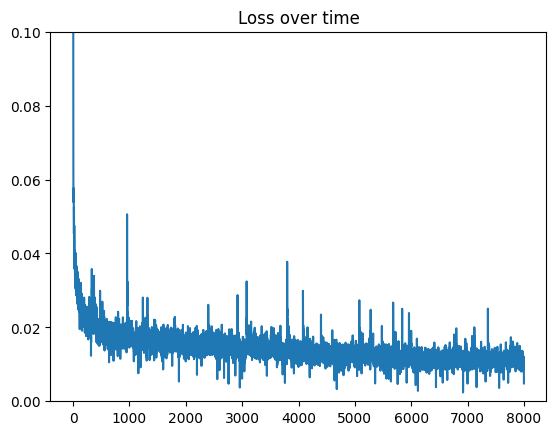

In [10]:
# Plot losses
fig, axs = plt.subplots()

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1);
axs.set_title('Loss over time')

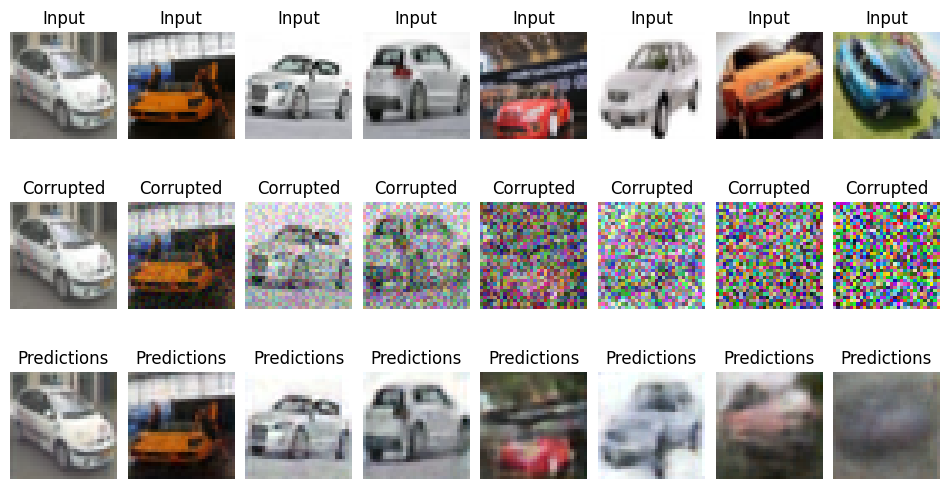

In [11]:
# Fetch some data
x, y = next(iter(train_dataloader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]).to(device) # Left to right -> more corruption
noised_x = corrupt(x.to(device), amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x, 0).sample

  predsCpu = preds.detach().cpu()
  # Convert the tensor to a NumPy array
  predsNum = predsCpu.numpy()

  noised_x = noised_x.detach().cpu()  
# Create subplots for each tensor
fig, axes = plt.subplots(3, 8, figsize=(12, 6))

# Define labels for each tensor
labels = ['Input', 'Corrupted', 'Predictions']

# Plot images and add labels
for row in range(3):
    tensor = [x, noised_x, predsNum][row]
    label = labels[row]

    for i in range(8):
        image = tensor[i]
        axes[row, i].imshow(np.transpose(image, (1, 2, 0)))
        axes[row, i].axis('off')
        axes[row, i].set_title(label)

# Adjust spacing and display the plot
plt.subplots_adjust(wspace=0.1, hspace=0.4)
plt.show()

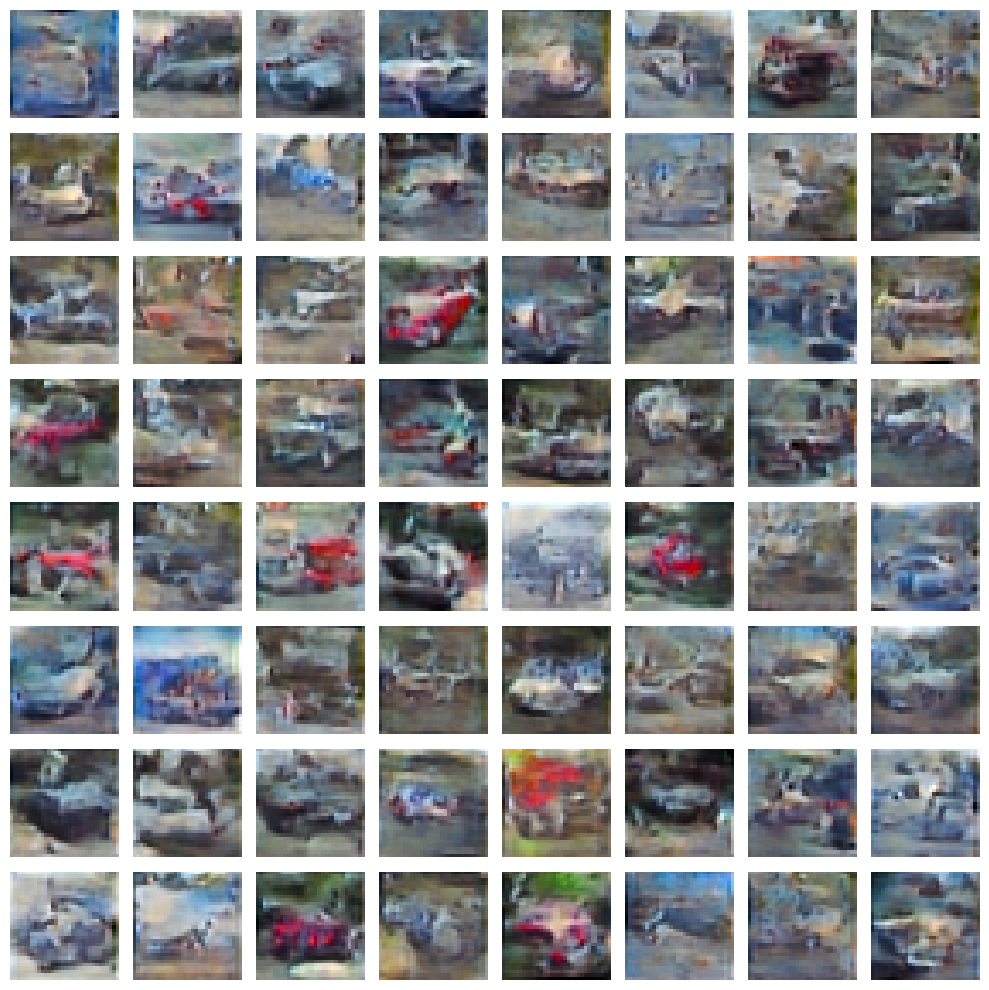

In [13]:
# Plot Samples

n_steps = 40
x = torch.rand(64, 3, 32, 32).to(device)
for i in range(n_steps):
  noise_amount = torch.ones((x.shape[0], )).to(device) * (1-(i/n_steps)) # Starting high going low
  with torch.no_grad():
    pred = net(x, 0).sample
  mix_factor = 1/(n_steps - i)
  x = x*(1-mix_factor) + pred*mix_factor

step_history = x.detach().cpu()

# Convert the tensor to a NumPy array
step_history = step_history.numpy()

# Reshape the tensor to have dimensions [64, 32, 32, 3]
step_history = np.transpose(step_history, (0, 2, 3, 1))

# Clip the pixel values to the valid range of [0, 1]
step_history = np.clip(step_history, 0, 1)

# Create a 8x8 grid of subplots to plot the 64 images
fig, axes = plt.subplots(8, 8, figsize=(10, 10))

# Flatten the 8x8 grid of axes into a 1-dimensional array
axes = axes.flatten()

# Iterate over each image and plot it on the corresponding subplot
for i, ax in enumerate(axes):
    ax.imshow(step_history[i])
    ax.axis('off')

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()